# 🎯 Confidence Score Calibration Demo

<div style="background-color: rgba(200, 200, 200, 0.1); padding: 20px; border-radius: 8px; margin-bottom: 20px; border: 1px solid rgba(127, 127, 127, 0.2); max-width: 97.5%; overflow-wrap: break-word;">
  <p style="font-size: 16px; line-height: 1.6">
     Confidence scores from uncertainty quantification methods may not be well-calibrated probabilities. This demo demonstrates how to transform raw confidence scores into calibrated probabilities that better reflect the true likelihood of correctness using the <code>ScoreCalibrator</code> class.
  </p>
</div>

## 📊 What You'll Do in This Demo

<div style="display: flex; margin-bottom: 15px; align-items: center">
  <div style="background-color: #34a853; color: white; border-radius: 50%; width: 30px; height: 30px; display: flex; justify-content: center; align-items: center; margin-right: 15px; flex-shrink: 0"><strong>1</strong></div>
  <div>
    <p style="margin: 0; font-weight: bold"><a href=#section1>Set up LLM and prompts.</a></p>
    <p style="margin: 0; color: rgba(95, 99, 104, 0.8)">Set up LLM instance and load example data prompts.</p>
  </div>
</div>

<div style="display: flex; margin-bottom: 15px; align-items: center">
  <div style="background-color: #34a853; color: white; border-radius: 50%; width: 30px; height: 30px; display: flex; justify-content: center; align-items: center; margin-right: 15px; flex-shrink: 0"><strong>2</strong></div>
  <div>
    <p style="margin: 0; font-weight: bold"><a href=#section2>Generate LLM Responses and Confidence Scores</a></p>
    <p style="margin: 0; color: rgba(95, 99, 104, 0.8)">Generate and score LLM responses to the example questions using the <code>WhiteBoxUQ()</code> class.</p>
  </div>
</div>

<div style="display: flex; margin-bottom: 25px; align-items: center">
  <div style="background-color: #34a853; color: white; border-radius: 50%; width: 30px; height: 30px; display: flex; justify-content: center; align-items: center; margin-right: 15px; flex-shrink: 0"><strong>3</strong></div>
  <div>
    <p style="margin: 0; font-weight: bold"><a href=#section3>Fit Calibrators and Evaluate on Holdout Set</a></p>
    <p style="margin: 0; color: rgba(95, 99, 104, 0.8)">Train confidence score calibrators and evaluate on holdout set of prompts.</p>
  </div>
</div>


## ⚖️ Calibration Methods

<div style="display: flex; gap: 20px">
  <div style="flex: 1; background-color: rgba(0, 100, 200, 0.1); padding: 15px; border-radius: 8px; border: 1px solid rgba(0, 100, 200, 0.2)">
    <h3 style="color: #1e40af; margin-top: 0">Platt Scaling</h3>
    <ul style="margin-bottom: 0">
      <li><strong>Method:</strong> Logistic regression</li>
      <li><strong>Parametric:</strong> Assumes sigmoid-shaped calibration function</li>
      <li><strong>Best for:</strong> Small datasets, well-behaved score distributions</li>
    </ul>
  </div>
  
  <div style="flex: 1; background-color: rgba(0, 200, 0, 0.1); padding: 15px; border-radius: 8px; border: 1px solid rgba(0, 200, 0, 0.2)">
    <h3 style="color: #2e8b57; margin-top: 0">Isotonic Regression</h3>
    <ul style="margin-bottom: 0">
      <li><strong>Method:</strong> Non-parametric, monotonic</li>
      <li><strong>Flexible:</strong> Can handle any monotonic calibration curve</li>
      <li><strong>Best for:</strong> Larger datasets, complex score distributions</li>
    </ul>
  </div>
</div>

In [1]:
from uqlm import WhiteBoxUQ
from uqlm.calibration import ScoreCalibrator, evaluate_calibration
from uqlm.utils import load_example_dataset, LLMGrader

## 1. Set up LLM and Prompts

For this demo, we'll sample 1500 prompts from the [NQ-Open benchmark](https://aclanthology.org/Q19-1026/). The first 1000 prompts will be used to train the calibrators and remaining 500 prompts will be used as a test dataset.

In [2]:
n_train, n_test = 1000, 500
n_prompts = n_train + n_test

# Load example dataset for prompts/answers (optional, for context)
nq_open = load_example_dataset("nq_open", n=n_prompts)

# Define prompts
QA_INSTRUCTION = "You will be given a question. Return only the answer as concisely as possible without providing an explanation.\n"
prompts = [QA_INSTRUCTION + prompt for prompt in nq_open.question]
train_prompts = prompts[:n_train]
test_prompts = prompts[-n_test:]

Loading dataset - nq_open...
Processing dataset...
Dataset ready!


In this example, we use `ChatVertexAI` to instantiate our LLM, but any [LangChain Chat Model](https://js.langchain.com/docs/integrations/chat/) may be used. Be sure to **replace with your LLM of choice.**

In [3]:
# import sys
# !{sys.executable} -m pip install langchain-google-vertexai
from langchain_google_vertexai import ChatVertexAI

llm = ChatVertexAI(model="gemini-2.5-flash")

<a id='section2'></a>
## 2. Compute Confidence Scores
We generate model responses and associated confidence scores by leveraging the `WhiteBoxUQ` class. This class generates responses to prompts, while also estimating a confidence score for each response using token probabilities.

In [4]:
wbuq = WhiteBoxUQ(llm=llm, scorers=["normalized_probability"])
uq_result = await wbuq.generate_and_score(prompts=train_prompts)

Output()

To obtain the labels for calibration, we 'grade' the responses against an answer key. Here, we use UQLM's out-of-the-box LLM Grader, which can be used with [LangChain Chat Model](https://js.langchain.com/docs/integrations/chat/), but you may replace this with a grading method of your choice. Some notable alternatives are [Vectara HHEM](https://huggingface.co/vectara/hallucination_evaluation_model) and [AlignScore](https://github.com/yuh-zha/AlignScore). **If you are using your own prompts/questions, be sure to update the grading method accordingly**.

In [6]:
# set up the LLM grader to grade LLM responses against the ground truth answer key (we need these grades for calibration)
gemini_flash_lite = ChatVertexAI(model="gemini-2.5-flash-lite")
grader = LLMGrader(llm=gemini_flash_lite)

# Convert to dataframe and grade responses against correct answers
result_df = uq_result.to_df()
result_df["response_correct"] = await grader.grade_responses(prompts=nq_open["question"].to_list()[:n_train], responses=result_df["response"].to_list(), answers=nq_open["answer"].to_list()[:n_train])
result_df.head()

,prompt,response,logprob,normalized_probability,response_correct
0,You will be given a question. Return only the ...,"December 14, 1972","[{'token': 'December', 'logprob': -0.044779419...",0.980881,True
1,You will be given a question. Return only the ...,Bobby Scott and Bob Russell,"[{'token': 'Bobby', 'logprob': -0.065702043473...",0.979054,True
2,You will be given a question. Return only the ...,1,"[{'token': '1', 'logprob': -0.0108721693977713...",0.989187,True
3,You will be given a question. Return only the ...,Super Bowl LII,"[{'token': 'Super', 'logprob': -1.586603045463...",0.672557,False
4,You will be given a question. Return only the ...,South Carolina,"[{'token': 'South', 'logprob': -1.502075701864...",0.999992,True


<a id='section3'></a>
## 3. Score Calibration
Confidence scores from uncertainty quantification methods may not be well-calibrated probabilities. You can transform raw confidence scores into calibrated probabilities that better reflect the true likelihood of correctness using the calibrate_scores method.

The first step is to train the claibrators that can done using `fit` or `fit_transform` method of `ScoreCalibrator` class. You can initiate a class object by choosing a method for training calibrators. Then call `fit_transform` method be providing `UQResult` object from training dataset and correct responses.

In [7]:
sc = ScoreCalibrator(method="isotonic")
sc.fit_transform(uq_result=uq_result, correct_indicators=result_df.response_correct)

results_df = uq_result.to_df()
results_df.head()

,prompt,response,logprob,normalized_probability,calibrated_normalized_probability
0,You will be given a question. Return only the ...,"December 14, 1972","[{'token': 'December', 'logprob': -0.044779419...",0.980881,0.628571
1,You will be given a question. Return only the ...,Bobby Scott and Bob Russell,"[{'token': 'Bobby', 'logprob': -0.065702043473...",0.979054,0.628571
2,You will be given a question. Return only the ...,1,"[{'token': '1', 'logprob': -0.0108721693977713...",0.989187,0.633929
3,You will be given a question. Return only the ...,Super Bowl LII,"[{'token': 'Super', 'logprob': -1.586603045463...",0.672557,0.490196
4,You will be given a question. Return only the ...,South Carolina,"[{'token': 'South', 'logprob': -1.502075701864...",0.999992,0.888889


You can evaluate the performance of calibrated scores using `evaluate_calibration` method, which will require the correct responses.

In [28]:
# Uncomment the following lines to visualize the calibrated scores

# metrics = sc_object.evaluate_calibration(results, result_df.response_correct)
# metrics

Lets generate responses and compute score on test dataset using `wbuq` object, which will return a `UQResult` object on test dataset which will contain test prompts, responses, and confidence scores.

In [29]:
test_result = await wbuq.generate_and_score(prompts=test_prompts)

Output()

We now have trained a `ScoreCalibrator` object containing fitted calibrators for each scorer (only `normalized_probability` for our example, but can be used with multiple scorers). Now, we can call `transform` method and provide a test dataset (UQResult object form test prompts), which will update the `UQResult` object to include calibrated scores.

Note: `transform` method updates `UQResult` object in place, such that for every 'score', it will also contain 'calibrated_score'.

In [30]:
# Calibrate scores
sc.transform(test_result)

test_result_df = test_result.to_df()
test_result_df.head()

,prompt,response,logprob,normalized_probability,calibrated_normalized_probability
0,You will be given a question. Return only the ...,Games,"[{'token': 'Games', 'logprob': -0.001829901477...",0.998172,0.578947
1,You will be given a question. Return only the ...,Amir Johnson,"[{'token': 'Am', 'logprob': -2.050269904430024...",0.999993,0.741935
2,You will be given a question. Return only the ...,Frank Morris,"[{'token': 'Frank', 'logprob': -8.653872646391...",0.999939,0.606061
3,You will be given a question. Return only the ...,"May 7, 1992","[{'token': 'May', 'logprob': -0.01998697593808...",0.996715,0.538462
4,You will be given a question. Return only the ...,Daisuke Ohata,"[{'token': 'D', 'logprob': -8.153352973749861e...",0.999962,0.647059


Lets evaluate calibrated score from test dataset (since we also have correct response on test dataset)

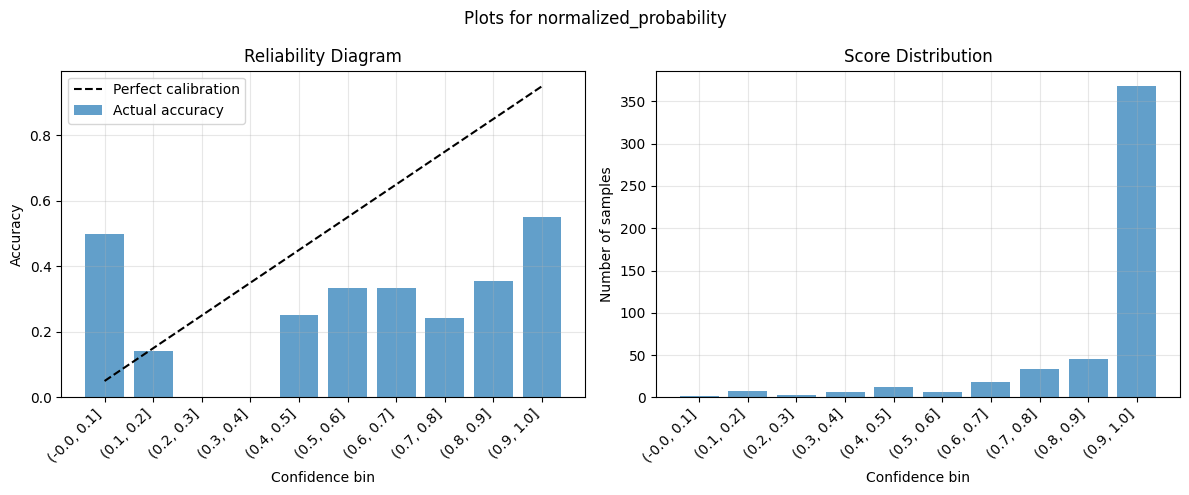

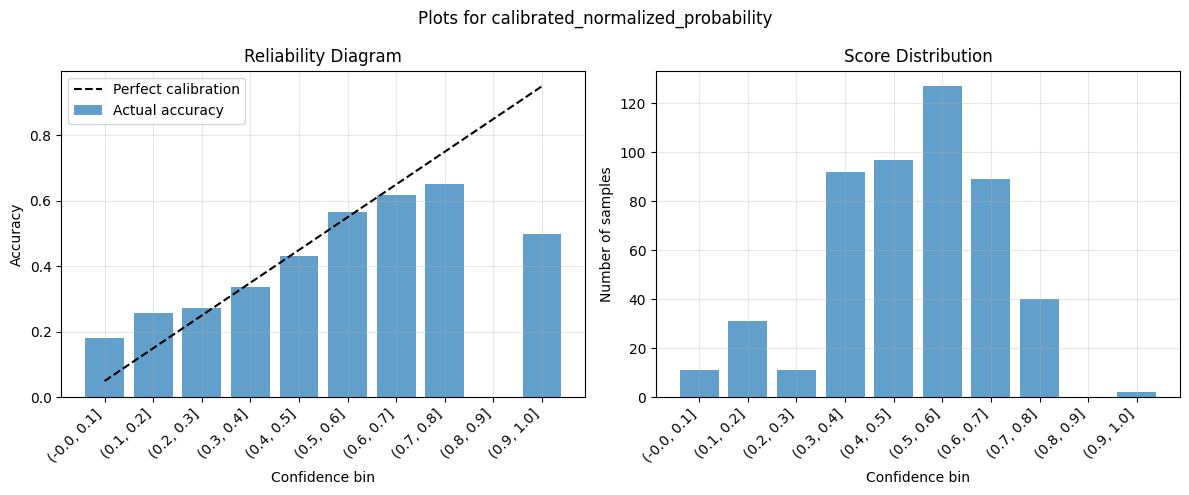

,average_confidence,average_accuracy,calibration_gap,brier_score,log_loss,ece,mce
normalized_probability,0.904642,0.48,0.424642,0.421297,2.586512,0.428037,0.511129
calibrated_normalized_probability,0.492642,0.48,0.012642,0.233129,0.793354,0.030675,0.500000


In [31]:
# Grade responses against correct answers for test set
test_result_df["response_correct"] = await grader.grade_responses(prompts=nq_open["question"].to_list()[-n_test:], responses=test_result_df["response"].to_list(), answers=nq_open["answer"].to_list()[-n_test:])

test_metrics = evaluate_calibration(test_result, test_result_df.response_correct)
test_metrics

Note the substantial improvement in calibration quality before and after transforming confidence scores with the fitted `ScoreCalibrator` object.

## 4. Summary

This calibration analysis demonstrates:

### 🎯 **Key Findings**

1. **Calibration Quality**: Use reliability diagrams and metrics like ECE and MCE score to assess how well confidence scores reflect true probabilities

2. **Method Selection**: 
   - **Platt Scaling** works well for smaller datasets and when the calibration curve is roughly sigmoid-shaped
   - **Isotonic Regression** is more flexible and can handle complex, non-parametric calibration curves

3. **Practical Impact**: Calibration can significantly improve:
   - Reliability of confidence scores for decision-making
   - User trust in model predictions

---

© 2025 CVS Health and/or one of its affiliates. All rights reserved.